In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [10]:
# Fix the seed to reproduce the results
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)           
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [11]:
# Load the dataset and do transformations
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
                         (0.2023, 0.1994, 0.2010))  # CIFAR-10 std
])

transform_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
                         (0.2023, 0.1994, 0.2010))  # CIFAR-10 std
])

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Split the dataset into training and validation
val_ratio = 0.2
train_indices = list(range(len(trainset_full)))
train_targets = trainset_full.targets

train_idx, val_idx = train_test_split(
    train_indices,
    test_size=val_ratio,
    stratify=train_targets,
    random_state=42
)

train_subset = Subset(trainset_full, train_idx)
val_subset = Subset(trainset_full, val_idx)

In [13]:
# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [14]:
def get_model(model_name, num_classes=10):
    if model_name == 'SimpleCNN':
        model = SimpleCNN(num_classes=num_classes)
    elif model_name == 'ResNet-18':
        model = models.resnet18(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif model_name == 'AlexNet':
        model = models.alexnet(pretrained=False)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)
    elif model_name == 'MobileNet':
        model = models.mobilenet_v2(pretrained=False)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif model_name == 'GoogleNet':
        model = models.googlenet(pretrained=False, aux_logits=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} is not supported.")
    return model

def train_model(model, trainloader, valloader, criterion, optimizer, device, epochs=25):
    model.to(device)
    best_val_acc = 0.0
    best_model_wts = model.state_dict()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / total_train
        epoch_acc = 100. * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        
        epoch_val_loss = val_loss / total_val
        epoch_val_acc = 100. * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        epoch_time = time.time() - start_time
        
        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% | '
              f'Val Loss: {epoch_val_loss:.4f} Val Acc: {epoch_val_acc:.2f}% | '
              f'Time: {epoch_time:.2f}s')
        
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict()
    
    model.load_state_dict(best_model_wts)
    return model, best_val_acc, train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_model(model, testloader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    avg_loss = test_loss / total
    print(f'Test Loss: {avg_loss:.4f} Test Accuracy: {accuracy:.2f}%')
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda

=== Model: ResNet-18 ===

Training with LR=0.1, Batch Size=32, Optimizer=SGD


c:\Users\samee\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samee\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/15] Train Loss: 1.8904 Train Acc: 30.30% | Val Loss: 1.5815 Val Acc: 41.77% | Time: 150.98s
Epoch [2/15] Train Loss: 1.3746 Train Acc: 49.53% | Val Loss: 1.5041 Val Acc: 48.28% | Time: 152.29s
Epoch [3/15] Train Loss: 1.0154 Train Acc: 64.14% | Val Loss: 1.0704 Val Acc: 62.34% | Time: 150.91s
Epoch [4/15] Train Loss: 0.8669 Train Acc: 70.01% | Val Loss: 1.1239 Val Acc: 62.88% | Time: 152.18s
Epoch [5/15] Train Loss: 0.7955 Train Acc: 72.41% | Val Loss: 0.9466 Val Acc: 68.26% | Time: 150.70s
Epoch [6/15] Train Loss: 0.7671 Train Acc: 73.66% | Val Loss: 0.8965 Val Acc: 68.79% | Time: 152.05s
Epoch [7/15] Train Loss: 0.7387 Train Acc: 74.63% | Val Loss: 0.8388 Val Acc: 71.97% | Time: 151.89s
Epoch [8/15] Train Loss: 0.7188 Train Acc: 75.43% | Val Loss: 0.9054 Val Acc: 70.49% | Time: 151.00s
Epoch [9/15] Train Loss: 0.7032 Train Acc: 75.73% | Val Loss: 0.7690 Val Acc: 73.33% | Time: 152.08s
Epoch [10/15] Train Loss: 0.6915 Train Acc: 76.06% | Val Loss: 0.9519 Val Acc: 68.50% | Tim

c:\Users\samee\anaconda3\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch [1/15] Train Loss: 1.8616 Train Acc: 30.49% | Val Loss: 1.9373 Val Acc: 35.35% | Time: 168.76s
Epoch [2/15] Train Loss: 1.3687 Train Acc: 50.20% | Val Loss: 1.3068 Val Acc: 52.73% | Time: 168.87s
Epoch [3/15] Train Loss: 1.1612 Train Acc: 58.60% | Val Loss: 1.5838 Val Acc: 44.18% | Time: 168.88s
Epoch [4/15] Train Loss: 1.0704 Train Acc: 61.95% | Val Loss: 1.2147 Val Acc: 58.43% | Time: 168.99s
Epoch [5/15] Train Loss: 0.9836 Train Acc: 65.47% | Val Loss: 1.4434 Val Acc: 54.96% | Time: 169.16s
Epoch [6/15] Train Loss: 0.9295 Train Acc: 67.67% | Val Loss: 1.0497 Val Acc: 62.85% | Time: 169.23s
Epoch [7/15] Train Loss: 0.8830 Train Acc: 69.11% | Val Loss: 1.3245 Val Acc: 59.52% | Time: 169.74s
Epoch [8/15] Train Loss: 0.8711 Train Acc: 69.81% | Val Loss: 1.1464 Val Acc: 59.47% | Time: 169.53s
Epoch [9/15] Train Loss: 0.8523 Train Acc: 70.50% | Val Loss: 1.6996 Val Acc: 50.40% | Time: 169.09s
Epoch [10/15] Train Loss: 0.8447 Train Acc: 71.11% | Val Loss: 1.9206 Val Acc: 44.07% | Tim

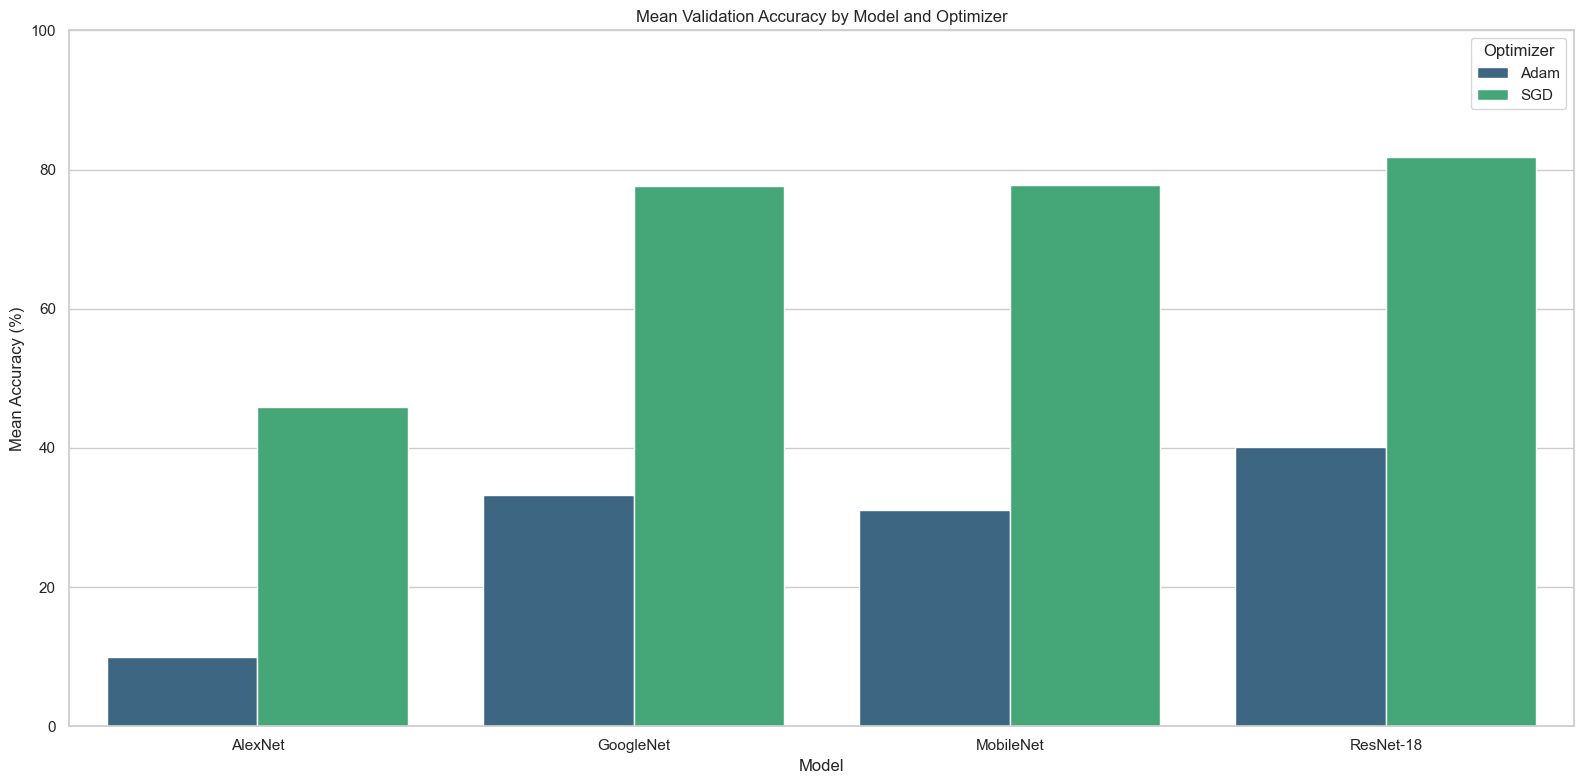

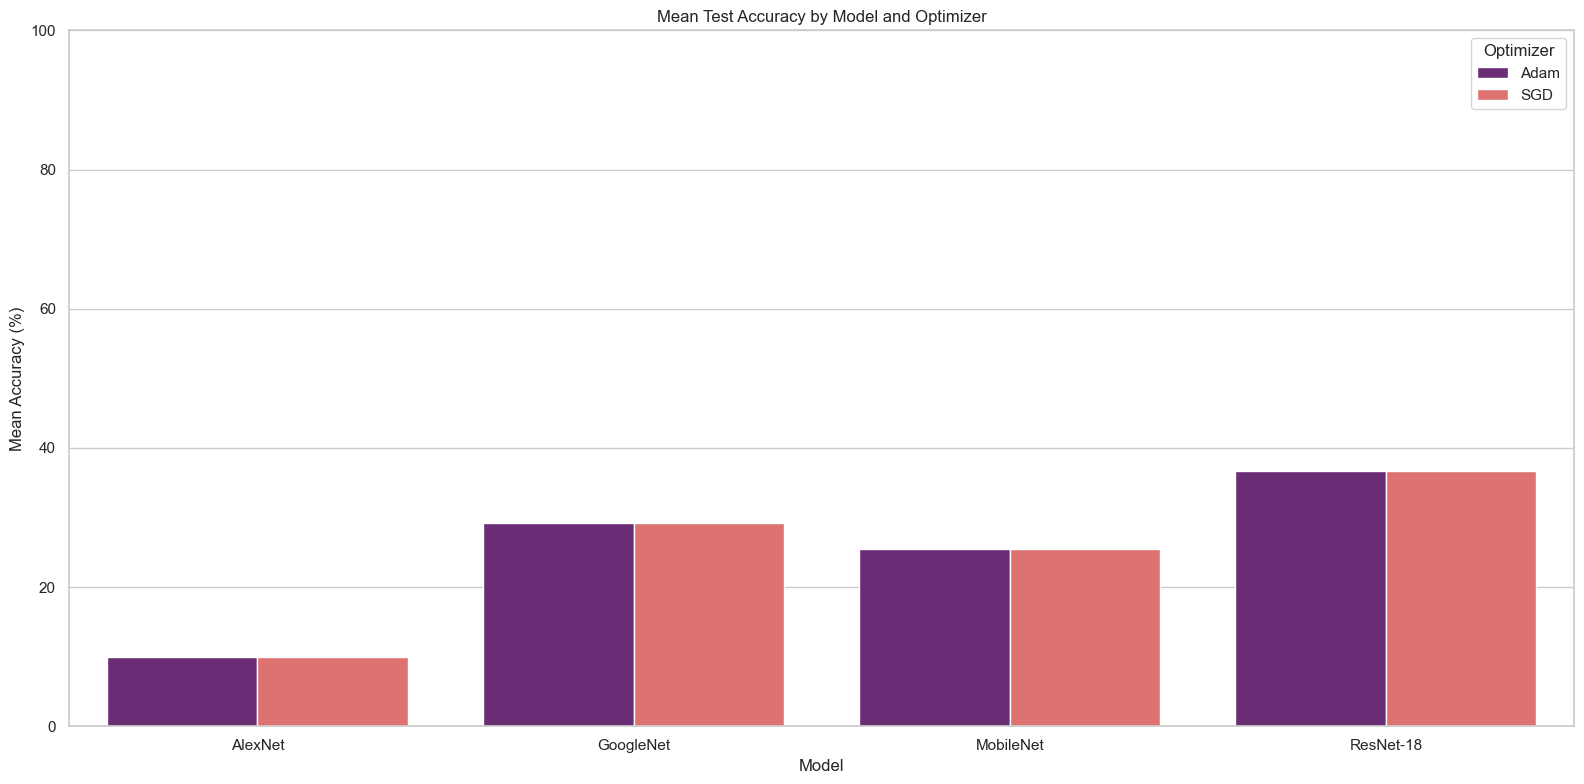

c:\Users\samee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


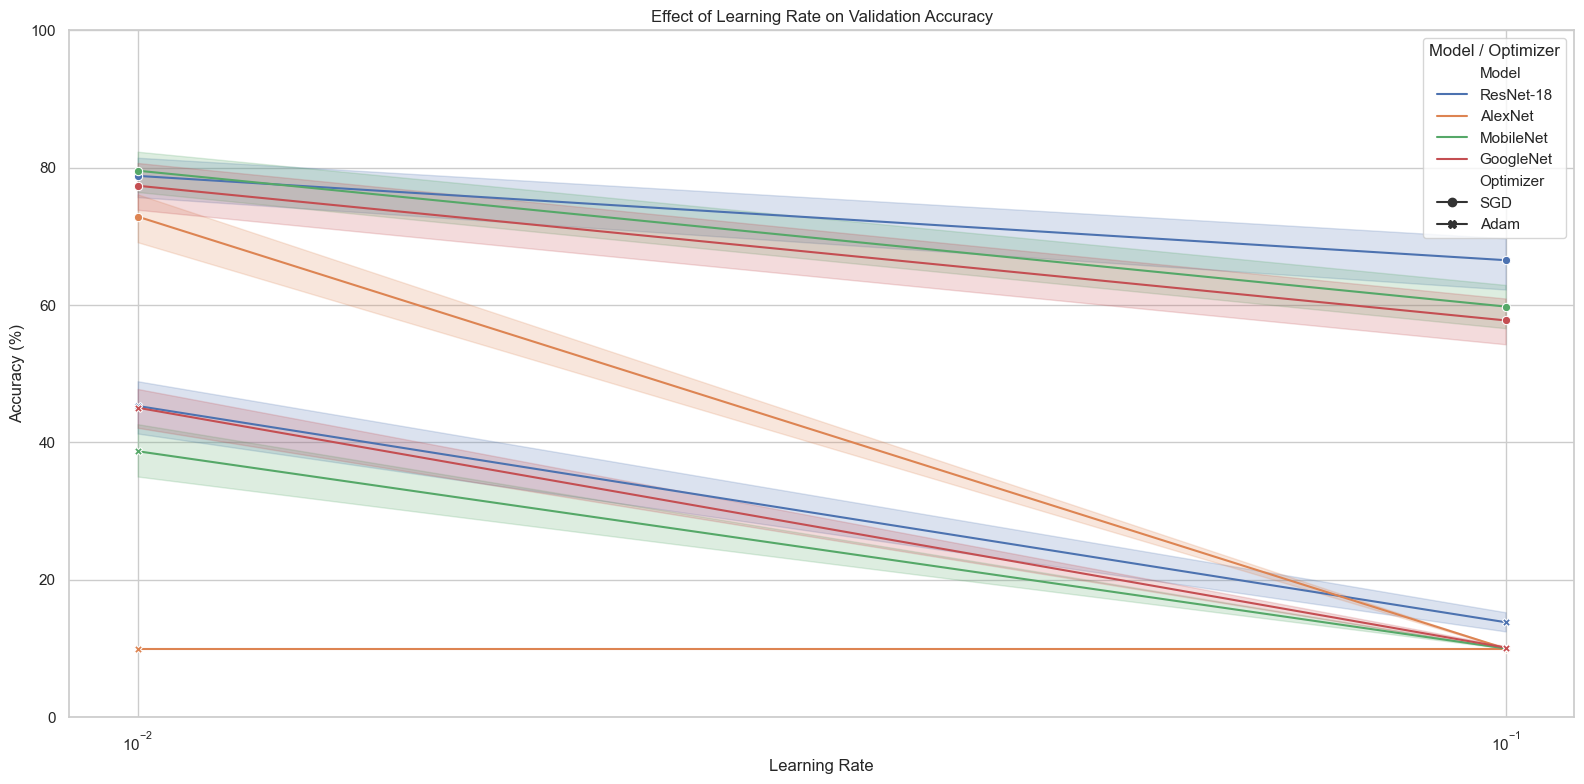

c:\Users\samee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


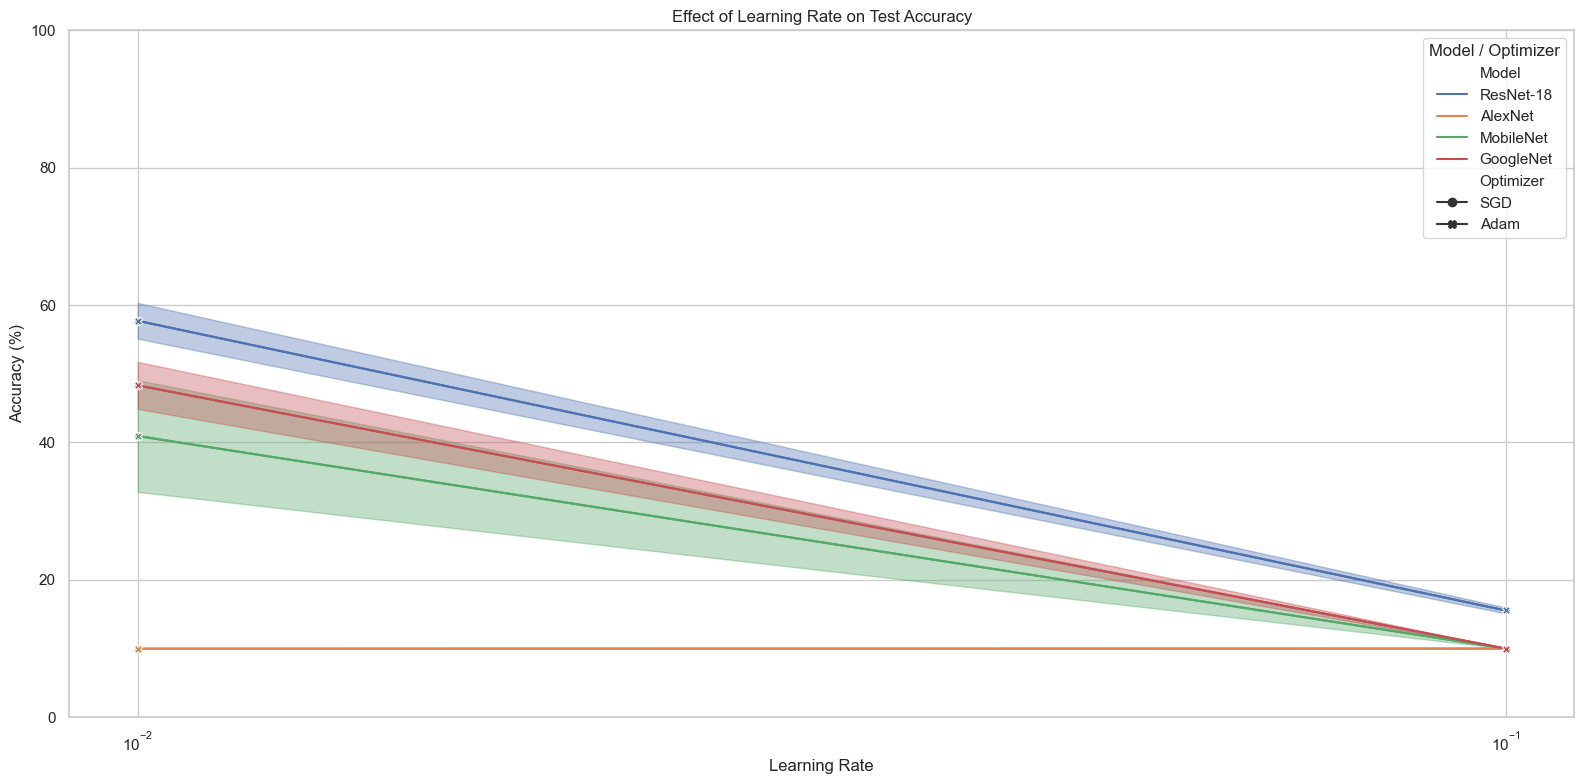

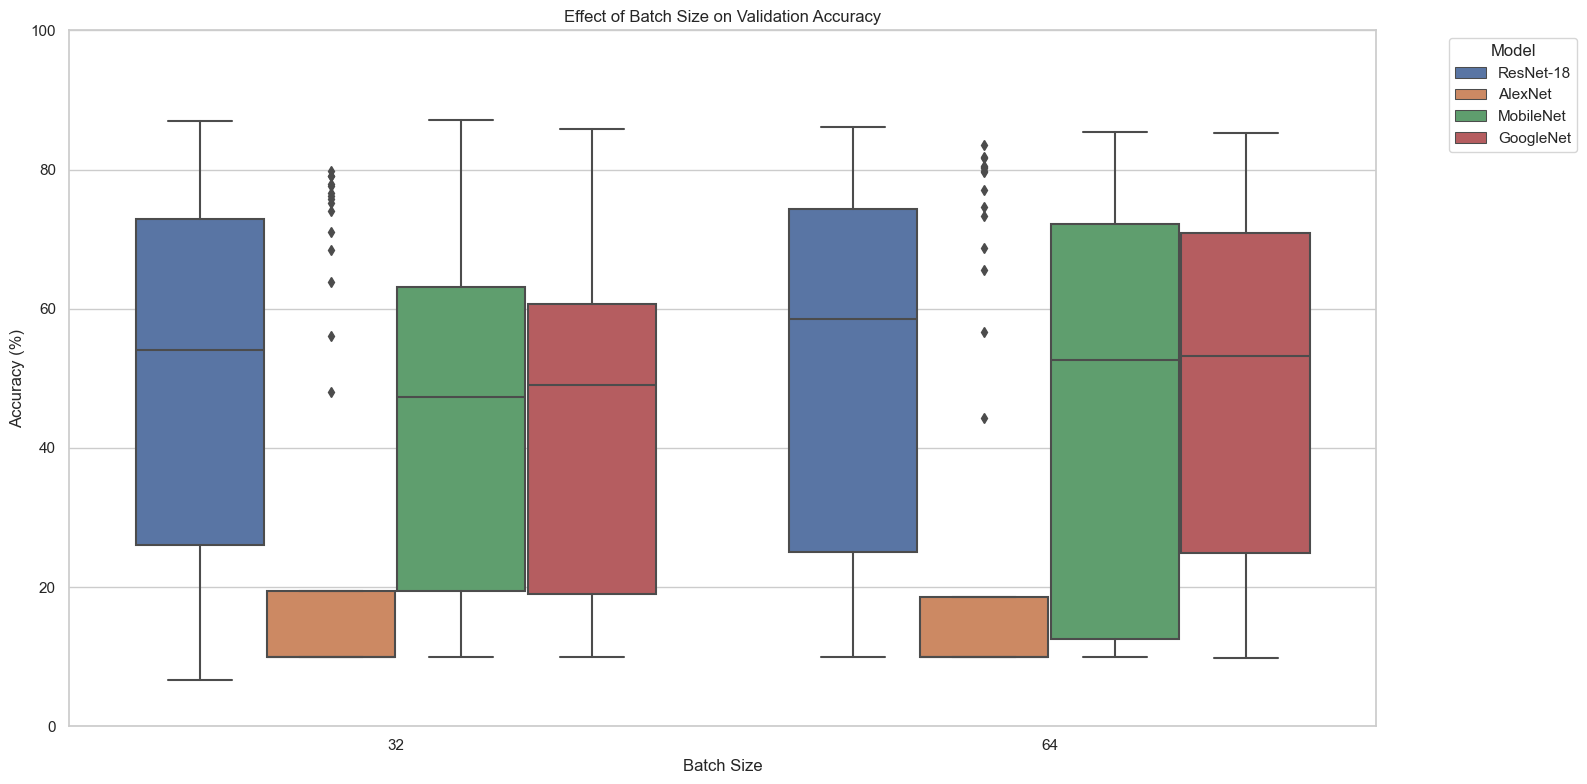

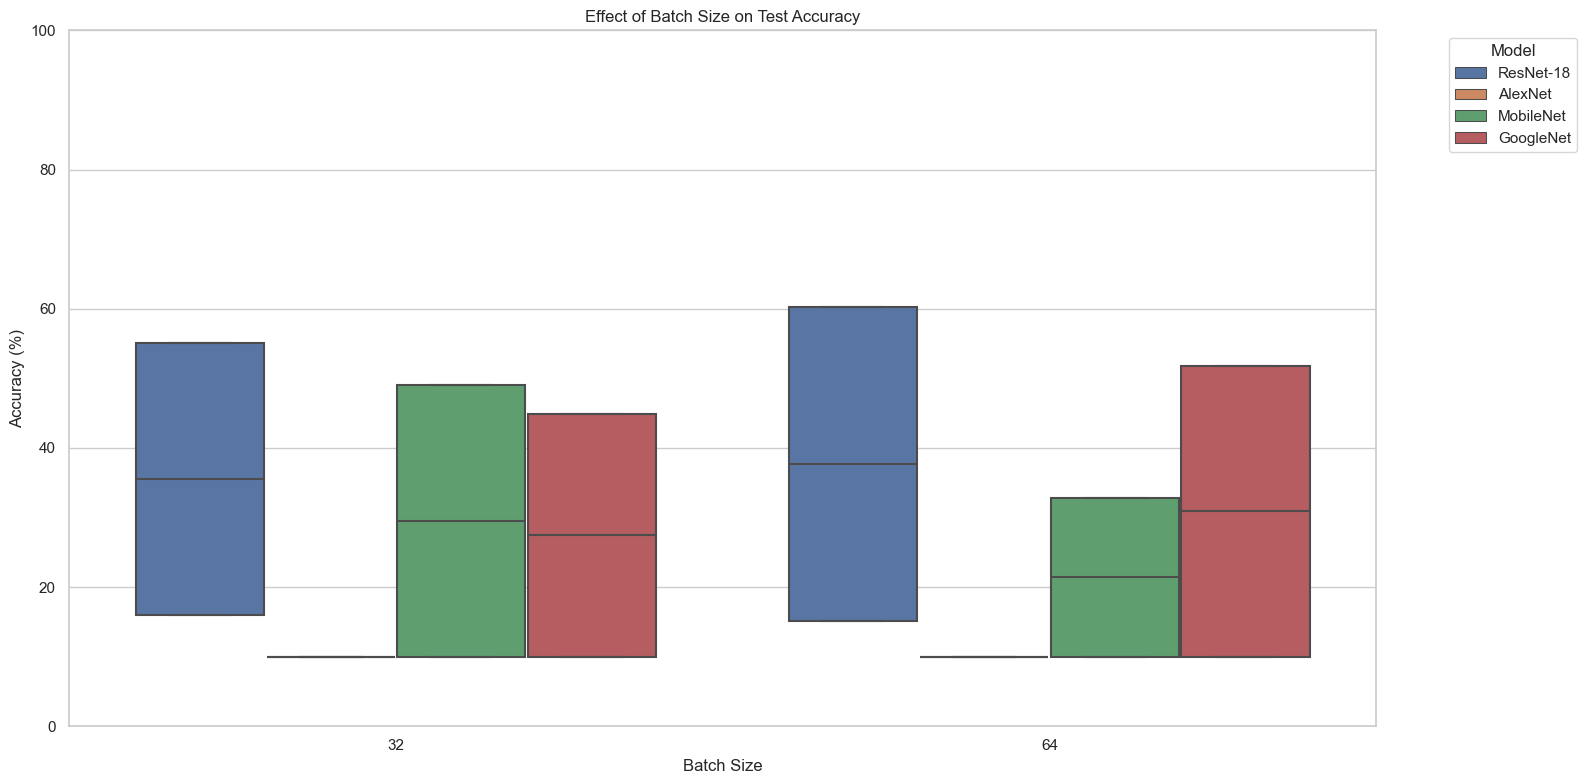

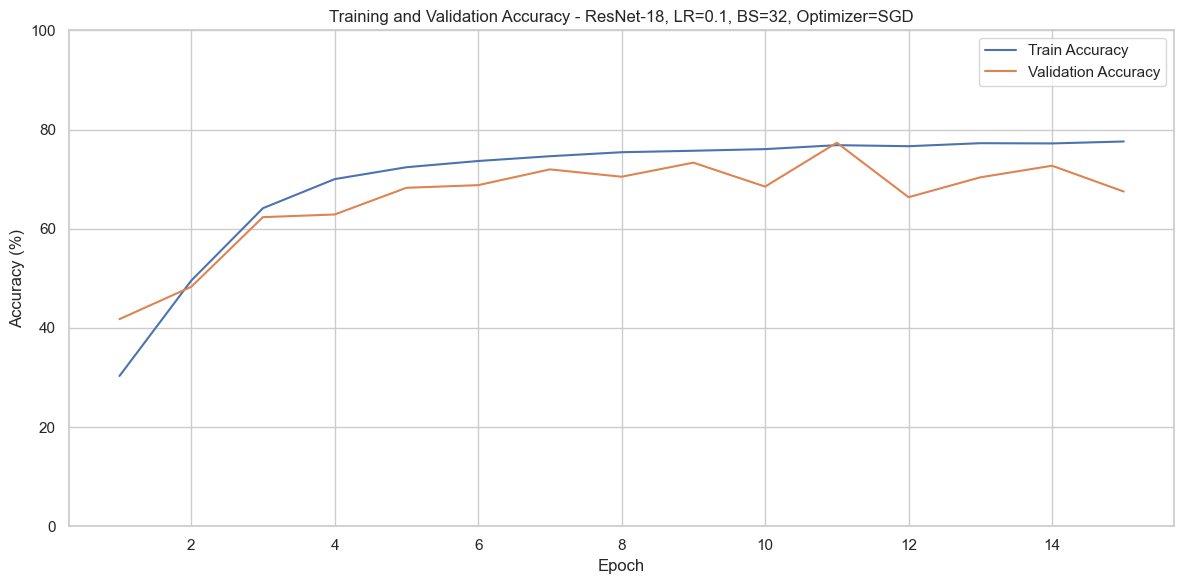

In [ ]:
learning_rates = [0.1, 0.01]
batch_sizes = [32, 64]
optimizers = ['SGD', 'Adam']
num_epochs = 15
model_names = ['SimpleCNN', 'ResNet-18', 'AlexNet', 'MobileNet', 'GoogleNet']
results_list = []
epoch_metrics_list = []
test_results_list = []

weights_dir = 'model_weights'
os.makedirs(weights_dir, exist_ok=True)

hyperparameter_combinations = list(product(learning_rates, batch_sizes, optimizers))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

for model_name in model_names:
    print(f'\n=== Model: {model_name} ===')
    for lr, batch_size, optimizer_name in hyperparameter_combinations:
        print(f'\nTraining with LR={lr}, Batch Size={batch_size}, Optimizer={optimizer_name}')
        trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        valloader = DataLoader(val_subset, batch_size=100, shuffle=False, num_workers=4)
        model = get_model(model_name)
        criterion = nn.CrossEntropyLoss()
        
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        
        trained_model, best_val_acc, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, trainloader, valloader, criterion, optimizer, device, epochs=num_epochs
        )
        
        new_record = {
            'Model': model_name,
            'Learning Rate': lr,
            'Batch Size': batch_size,
            'Optimizer': optimizer_name,
            'Validation Accuracy': best_val_acc,
            'Training Losses': train_losses,
            'Training Accuracies': train_accuracies,
            'Validation Losses': val_losses,
            'Validation Accuracies': val_accuracies
        }
        results_list.append(new_record)
        
        for epoch in range(len(train_losses)):
            epoch_record = {
                'Model': model_name,
                'Learning Rate': lr,
                'Batch Size': batch_size,
                'Optimizer': optimizer_name,
                'Epoch': epoch + 1,
                'Train Loss': train_losses[epoch],
                'Train Accuracy': train_accuracies[epoch],
                'Validation Loss': val_losses[epoch],
                'Validation Accuracy': val_accuracies[epoch]
            }
            epoch_metrics_list.append(epoch_record)
        
        weight_filename = f'{weights_dir}/{model_name}_lr{lr}_bs{batch_size}_opt{optimizer_name}_best.pth'
        torch.save(trained_model.state_dict(), weight_filename)
        print(f'Best model weights saved to {weight_filename} with best validation accuracy {best_val_acc:.2f}%')

results_df = pd.DataFrame(results_list)
results_df.to_csv('results/experiment_validation_results.csv', index=False)
epoch_metrics_df = pd.DataFrame(epoch_metrics_list)
epoch_metrics_df.to_csv('results/experiment_epoch_metrics.csv', index=False)

print("\n=== Evaluating Best Models on Test Set ===")
for record in results_list:
    model_name = record['Model']
    lr = record['Learning Rate']
    bs = record['Batch Size']
    opt = record['Optimizer']
    val_acc = record['Validation Accuracy']
    
    print(f'\nEvaluating Model: {model_name}, LR: {lr}, BS: {bs}, Optimizer: {opt}')
    weight_filename = f'{weights_dir}/{model_name}_lr{lr}_bs{bs}_opt{opt}_best.pth'
    model = get_model(model_name)
    model.load_state_dict(torch.load(weight_filename))
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
    test_acc = evaluate_model(model, testloader, device)
    
    new_test_record = {
        'Model': model_name,
        'Learning Rate': lr,
        'Batch Size': bs,
        'Optimizer': opt,
        'Test Accuracy': test_acc
    }
    test_results_list.append(new_test_record)

test_results_df = pd.DataFrame(test_results_list)
test_results_df.to_csv('results/experiment_test_results.csv', index=False)

Epoch Metrics Data:
       Model  Learning Rate  Batch Size Optimizer  Epoch  Train Loss  \
0  ResNet-18            0.1          32       SGD      1    1.890443   
1  ResNet-18            0.1          32       SGD      2    1.374598   
2  ResNet-18            0.1          32       SGD      3    1.015436   
3  ResNet-18            0.1          32       SGD      4    0.866944   
4  ResNet-18            0.1          32       SGD      5    0.795519   

   Train Accuracy  Validation Loss  Validation Accuracy  
0         30.3000         1.581535                41.77  
1         49.5325         1.504057                48.28  
2         64.1450         1.070390                62.34  
3         70.0100         1.123917                62.88  
4         72.4075         0.946562                68.26  

Validation Results Data:
       Model  Learning Rate  Batch Size Optimizer  Validation Accuracy  \
0  ResNet-18           0.10          32       SGD                77.35   
1  ResNet-18           0.

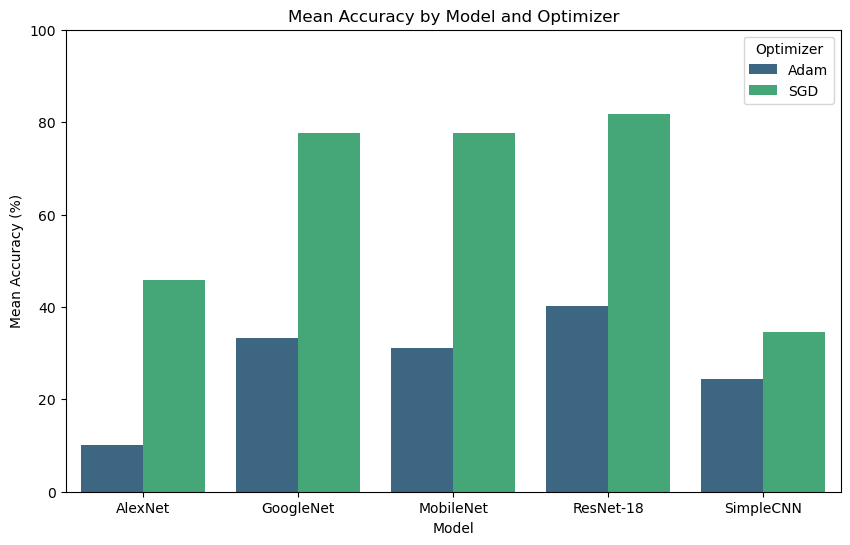

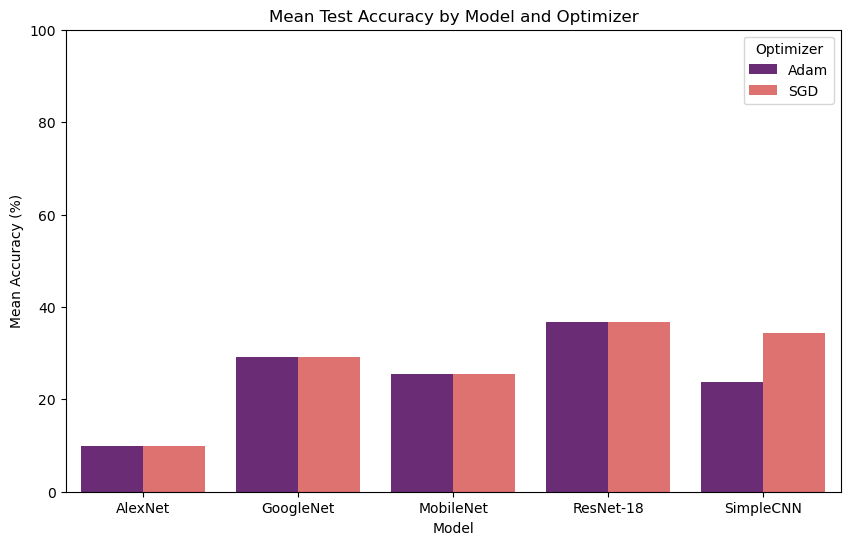

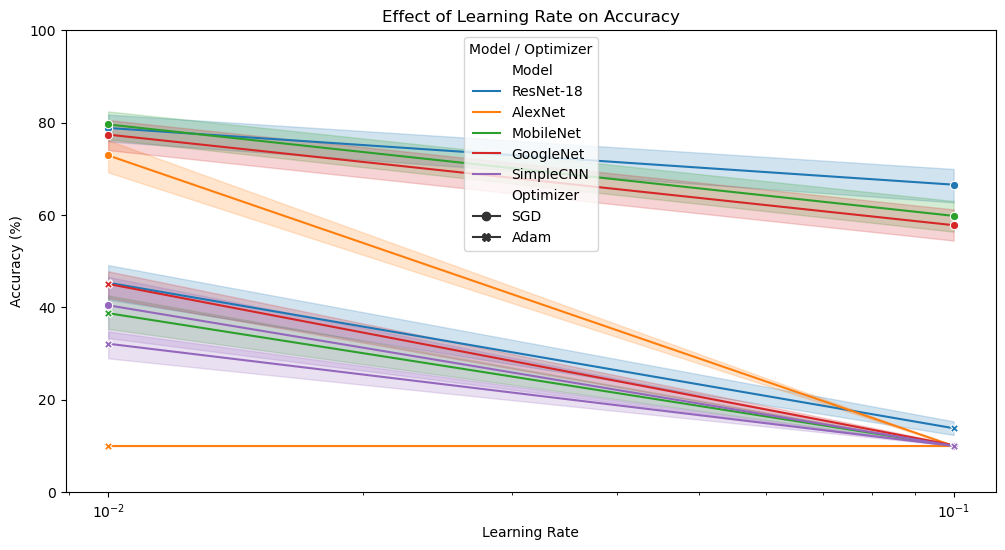

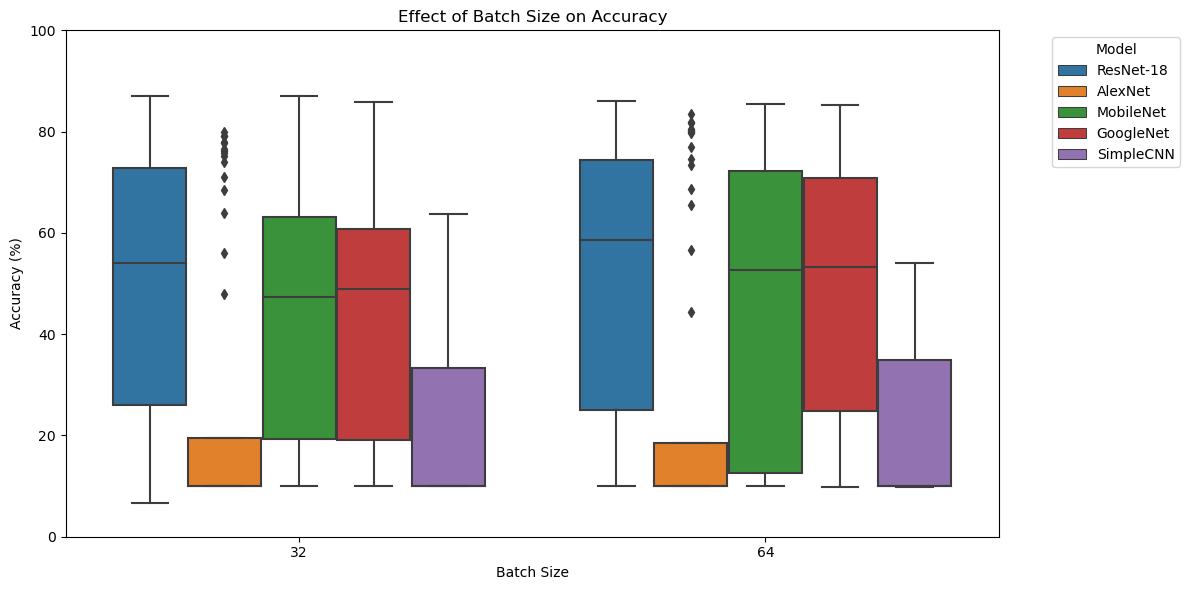

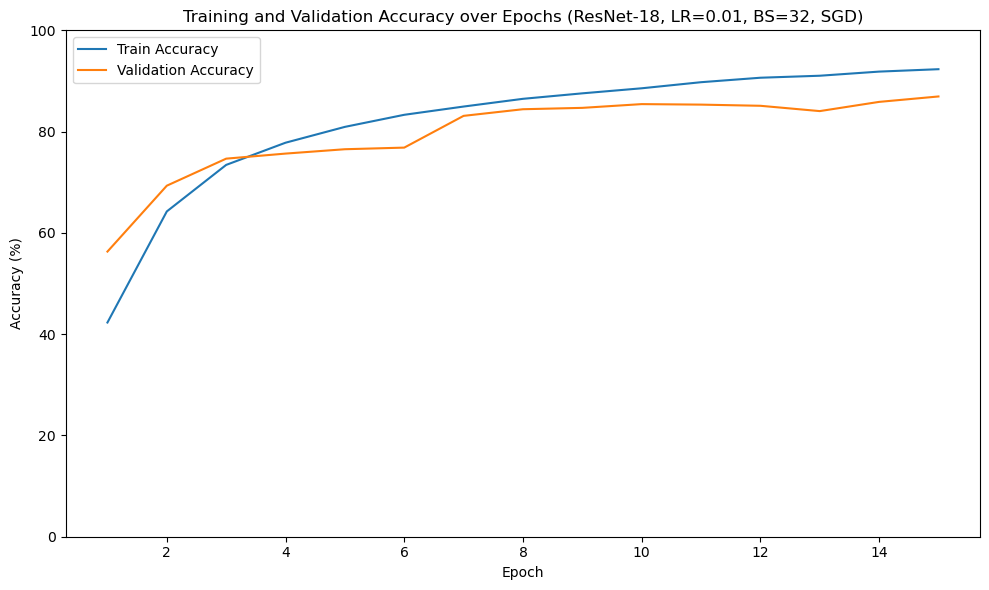

In [ ]:
# Load the saved data and draw visualization
epoch_metrics_df = pd.read_csv('results/experiment_epoch_metrics.csv')
validation_results_df = pd.read_csv('results/experiment_validation_results.csv')
test_results_df = pd.read_csv('results/experiment_test_results.csv')

print("Epoch Metrics Data:")
print(epoch_metrics_df.head())
print("\nValidation Results Data:")
print(validation_results_df.head())
print("\nTest Results Data:")
print(test_results_df.head())

summary_val = validation_results_df.groupby(['Model', 'Optimizer'])['Validation Accuracy'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Validation Accuracy', hue='Optimizer', data=summary_val, palette='viridis')
plt.title('Mean Accuracy by Model and Optimizer')
plt.ylabel('Mean Accuracy (%)')
plt.ylim(0, 100)
plt.legend(title='Optimizer')
plt.show()

summary_test = test_results_df.groupby(['Model', 'Optimizer'])['Test Accuracy'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test Accuracy', hue='Optimizer', data=summary_test, palette='magma')
plt.title('Mean Test Accuracy by Model and Optimizer')
plt.ylabel('Mean Accuracy (%)')
plt.ylim(0, 100)
plt.legend(title='Optimizer')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Learning Rate', y='Validation Accuracy', hue='Model', style='Optimizer', markers=True, dashes=False, data=epoch_metrics_df)
plt.title('Effect of Learning Rate on Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Learning Rate')
plt.xscale('log')
plt.ylim(0, 100)
plt.legend(title='Model / Optimizer')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Batch Size', y='Validation Accuracy', hue='Model', data=epoch_metrics_df)
plt.title('Effect of Batch Size on Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

subset = epoch_metrics_df[
    (epoch_metrics_df['Model'] == 'ResNet-18') &
    (epoch_metrics_df['Learning Rate'] == 0.01) &
    (epoch_metrics_df['Batch Size'] == 32) &
    (epoch_metrics_df['Optimizer'] == 'SGD')
]

plt.figure(figsize=(10, 6))
plt.plot(subset['Epoch'], subset['Train Accuracy'], label='Train Accuracy')
plt.plot(subset['Epoch'], subset['Validation Accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs (ResNet-18, LR=0.01, BS=32, SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Best Configuration for Each Model:
       Model  Learning Rate  Batch Size Optimizer  Test Accuracy
0    AlexNet           0.10          32       SGD          10.00
1  GoogleNet           0.01          64       SGD          51.74
2  MobileNet           0.01          32       SGD          49.07
3  ResNet-18           0.01          64       SGD          60.32
4  SimpleCNN           0.01          32       SGD          63.62


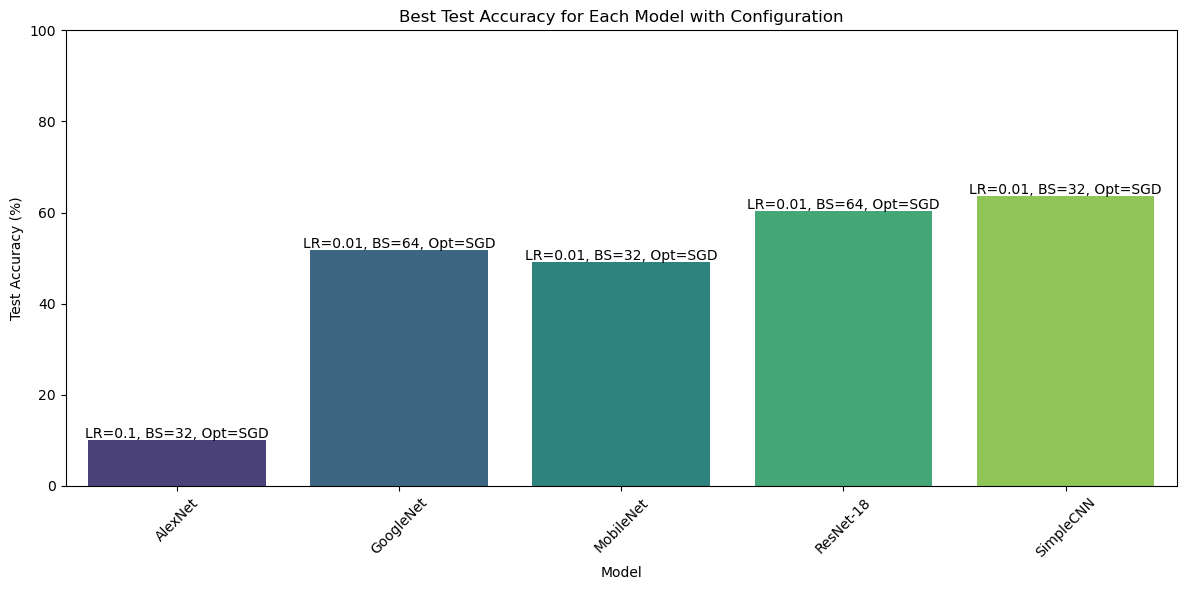

In [ ]:
best_models = test_results_df.loc[test_results_df.groupby('Model')['Test Accuracy'].idxmax()].reset_index(drop=True)
print("Best Configuration for Each Model:")
print(best_models)

plt.figure(figsize=(12, 6))
sns.barplot(data=best_models, x='Model', y='Test Accuracy', palette='viridis')
for i, row in best_models.iterrows():
    config = f"LR={row['Learning Rate']}, BS={row['Batch Size']}, Opt={row['Optimizer']}"
    plt.text(i, row['Test Accuracy'] + 0.5, config, ha='center', fontsize=10, color='black')
plt.title("Best Test Accuracy for Each Model with Configuration")
plt.ylabel("Test Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


         Model  Learning Rate  Batch Size Optimizer  Epoch  Train Loss  \
540  SimpleCNN           0.01          32       SGD      1    2.249155   
541  SimpleCNN           0.01          32       SGD      2    2.137814   
542  SimpleCNN           0.01          32       SGD      3    1.892388   
543  SimpleCNN           0.01          32       SGD      4    1.710818   
544  SimpleCNN           0.01          32       SGD      5    1.593316   

     Train Accuracy  Validation Loss  Validation Accuracy  
540         14.4725         2.137563                18.82  
541         19.3725         1.936857                27.00  
542         30.3375         1.654884                39.52  
543         37.4375         1.509550                46.75  
544         42.0325         1.363641                51.15  


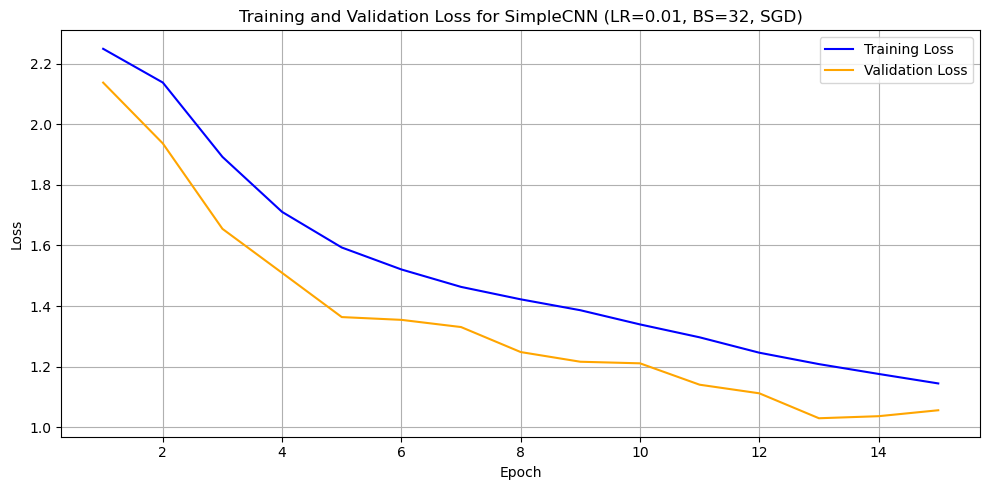

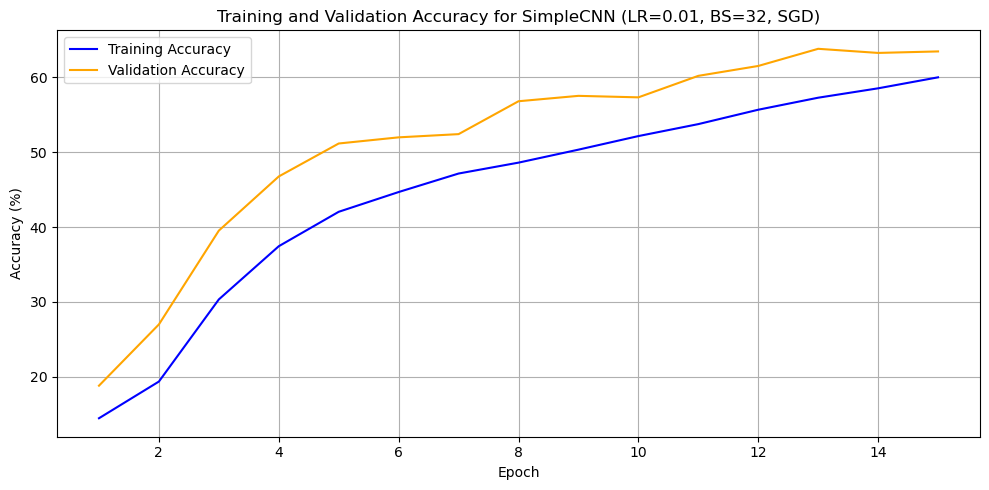

In [ ]:
filtered_data = epoch_metrics_df[
    (epoch_metrics_df['Model'] == 'SimpleCNN') &
    (epoch_metrics_df['Learning Rate'] == 0.01) &
    (epoch_metrics_df['Batch Size'] == 32) &
    (epoch_metrics_df['Optimizer'] == 'SGD')
]
print(filtered_data.head())

plt.figure(figsize=(10, 5))
plt.plot(filtered_data['Epoch'], filtered_data['Train Loss'], label='Training Loss', color='blue')
plt.plot(filtered_data['Epoch'], filtered_data['Validation Loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss for SimpleCNN (LR=0.01, BS=32, SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(filtered_data['Epoch'], filtered_data['Train Accuracy'], label='Training Accuracy', color='blue')
plt.plot(filtered_data['Epoch'], filtered_data['Validation Accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy for SimpleCNN (LR=0.01, BS=32, SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
